# Image Restoration

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_contra_harmonic_pixel(src, x, y, Q, M):
    
    numerator = np.sum(np.power(src[y-M: y+M, x-M:x+M], Q+1))
    denominator = np.sum(np.power(src[y-M: y+M, x-M:x+M], Q))

    if   denominator == 0 and numerator == 0: return 0
    if   denominator == 0 : return 255
    if   numerator   == np.inf and denominator != np.inf: return 255
    if   numerator   == np.inf or denominator == np.inf: return 0
    if   numerator   != numerator or denominator != denominator: return 0

    filter_val  = numerator/denominator
    
    return filter_val


def apply_contra_harmonic_filter(src, Q, M, use_float = False):
    if use_float:
      src = src/255.0
    src_w_border      = cv2.copyMakeBorder(src, M, M, M, M, borderType=cv2.BORDER_REFLECT)
    dst                       = np.ones_like(src_w_border) * 255
    height, width, *_  = src_w_border.shape

    for col in (range(M, width-M)):
        for row in range(M, height-M):
            dst[row, col] = get_contra_harmonic_pixel(src_w_border, col, row, Q, M)
    dst = dst[M:height-M, M:width-M]

    if use_float:
      return (dst *255).astype(np.uint8)
    
    return dst

def get_neighborhood(src, x, y, m):
    neigh = src[y - m : y + m + 1, x - m : x + m + 1] 
    return neigh

def get_min_med_max(neigh):
    min_val  = np.min(neigh)
    med_val  = np.median(neigh)
    max_val  = np.max(neigh)
    
    return min_val, med_val, max_val


def adaptive_median_filter(src, M_MAX):
    src_noise_wb      = cv2.copyMakeBorder(src, M_MAX, M_MAX, M_MAX, M_MAX, borderType=cv2.BORDER_REFLECT).astype(np.int)
    dst               = np.zeros_like(src_noise_wb, dtype=np.int)
    height, width, *_ = dst.shape

    for col in (range(M_MAX, width-M_MAX)):
        for row in range(M_MAX, height-M_MAX):
            dst[row, col] = stage_A(src_noise_wb, col, row, M_MAX)
        
    dst = dst[M_MAX:height-M_MAX, M_MAX:width-M_MAX]
    return dst

def stage_A(src, x, y, M_MAX, m=1):
    neigh             = get_neighborhood(src, x, y, m)
    zmin, zmed, zmax  = get_min_med_max(neigh)
    A1 = zmed - zmin
    A2 = zmed - zmax

    if A1 > 0 and A2 < 0:  
        return stage_B(src, x, y, m)  
    
    if m < M_MAX:
        return stage_A(src, x, y, M_MAX, m+1)
    else:
        return zmed

def stage_B(src, x, y, m):
    neigh            = get_neighborhood(src, x, y, m)
    zmin, zmed, zmax = get_min_med_max(neigh)
    zcurr            = src[y, x] 
    
    B1 = zcurr - zmin
    B2 = zcurr - zmax
    if B1 > 0 and B2 < 0:
        return zcurr          

    return zmed  

def plot_comparison(img1, img2 ,img3, title1, title2, title3, SIZE = 15):
    mse_12 = np.mean((img1.astype(np.int) - img2) ** 2)
    mse_13 =  np.mean((img1.astype(np.int) - img3) ** 2)
    plt.figure(figsize = (2*SIZE, 2*SIZE))
    plt.subplot(131);plt.title(title1);plt.imshow(img1, cmap = 'gray');plt.axis("off")
    plt.subplot(132);plt.title(title2 + f" | MSE: {mse_12:0.2f}");plt.imshow(img2, cmap = 'gray');plt.axis("off")
    plt.subplot(133);plt.title(title3 + f" | MSE: {mse_13:0.2f}");plt.imshow(img3, cmap = 'gray');plt.axis("off")
    plt.show()

def plot_comparison_3channels(img1, img2, img3,SIZE = 15):
    mse_12 = np.mean((img1.astype(np.int) - img2) ** 2)
    mse_13 =  np.mean((img1.astype(np.int) - img3) ** 2)
    plt.figure(figsize = (2*SIZE, 2*SIZE))
    plt.subplot(141);plt.title("Original Image");plt.imshow(img1[:,:,::-1]);plt.axis("off")
    plt.subplot(142);plt.title(f"Restored Image | MSE: {mse_12:0.2f}");plt.imshow(img2[:,:,::-1]);plt.axis("off")
    plt.subplot(143);plt.title(f"Noisy Image | MSE: {mse_13:0.2f}");plt.imshow(img3[:,:,::-1]);plt.axis("off")
    plt.show()

def plot3hist(r, g, b, SIZE = 15):
    plt.figure(figsize = (SIZE, SIZE))
    plt.subplot(231), plt.hist(r.ravel(), bins = 256, range = (0,256), color = "red")
    plt.subplot(232), plt.hist(g.ravel(), bins = 256, range = (0,256), color = "green")
    plt.subplot(233), plt.hist(b.ravel(), bins = 256, range = (0,256), color = "blue")
    plt.show()

def plot_channels(r, g, b, SIZE = 15):
    plt.figure(figsize = (SIZE, SIZE))
    plt.subplot(231), plt.imshow(r, cmap = "gray"); plt.axis("off")
    plt.subplot(232), plt.imshow(g, cmap = "gray"); plt.axis("off")
    plt.subplot(233), plt.imshow(b, cmap = "gray"); plt.axis("off")
    plt.show()

## Loading ground-truth images for future comparison

In [3]:
strawberry_original = cv2.imread("strawberries_coffee.png")
strawberry_red_original = strawberry_original[:,:,2]
strawberry_green_original = strawberry_original[:,:,1]
strawberry_blue_original = strawberry_original[:,:,0]


bar_original = cv2.imread("color_bar.png")
bar_red_original = bar_original[:,:,2]
bar_green_original = bar_original[:,:,1]
bar_blue_original = bar_original[:,:,0]

## Analyzing noisy images

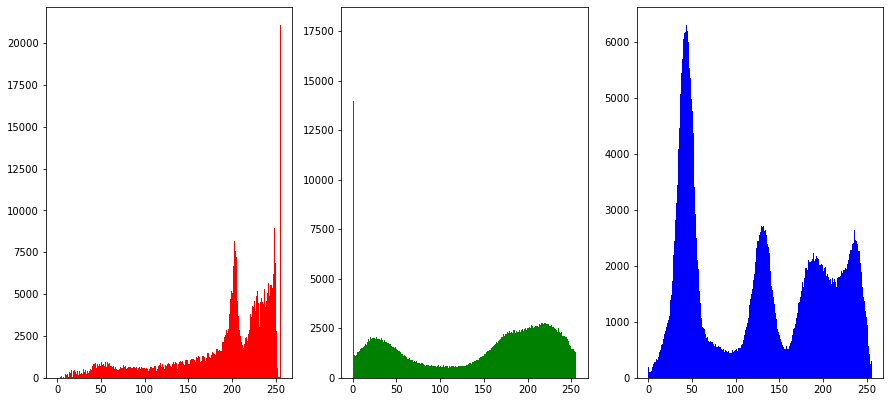

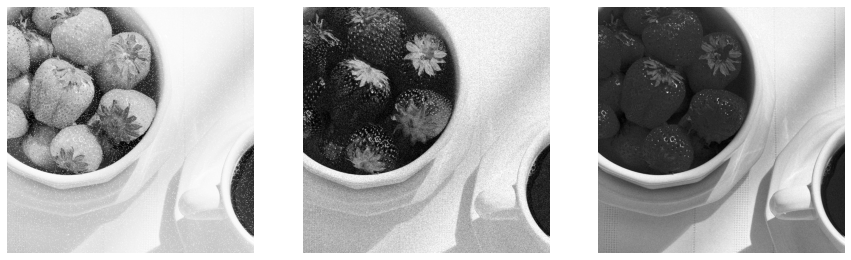

In [4]:
strawberry = cv2.imread("strawberries_coffee_noise.png")
strawberry_red = strawberry[:,:,2]
strawberry_green = strawberry[:,:,1]
strawberry_blue = strawberry[:,:,0]

plot3hist(strawberry_red, strawberry_green, strawberry_blue)

plot_channels(strawberry_red, strawberry_green, strawberry_blue)

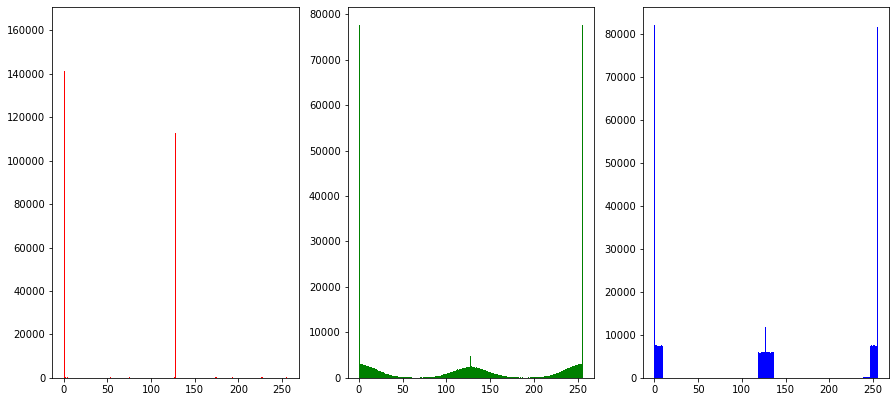

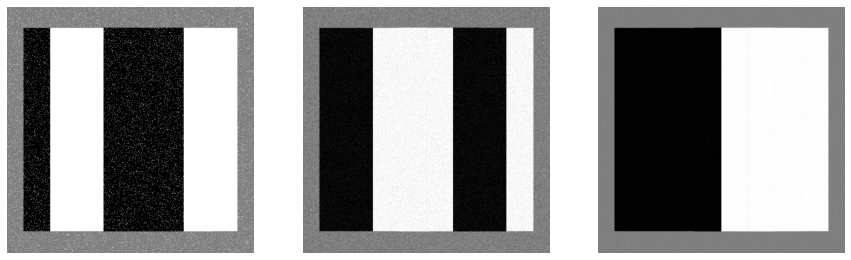

In [5]:
bar_noise = cv2.imread("bar_noise.png")

bar_red = bar_noise[:,:,2]
bar_green = bar_noise[:,:,1]
bar_blue = bar_noise[:,:,0]

plot3hist(bar_red, bar_green, bar_blue)

plot_channels(bar_red, bar_green, bar_blue)

## Ansatz:
- Red channel: Salt additive noise

- Green channel: Gaussian additive noise

- Blue channel: Normal additive noise

## Red channel

Contra-harmonic filter with negative Q

/home/ggc5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ggc5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


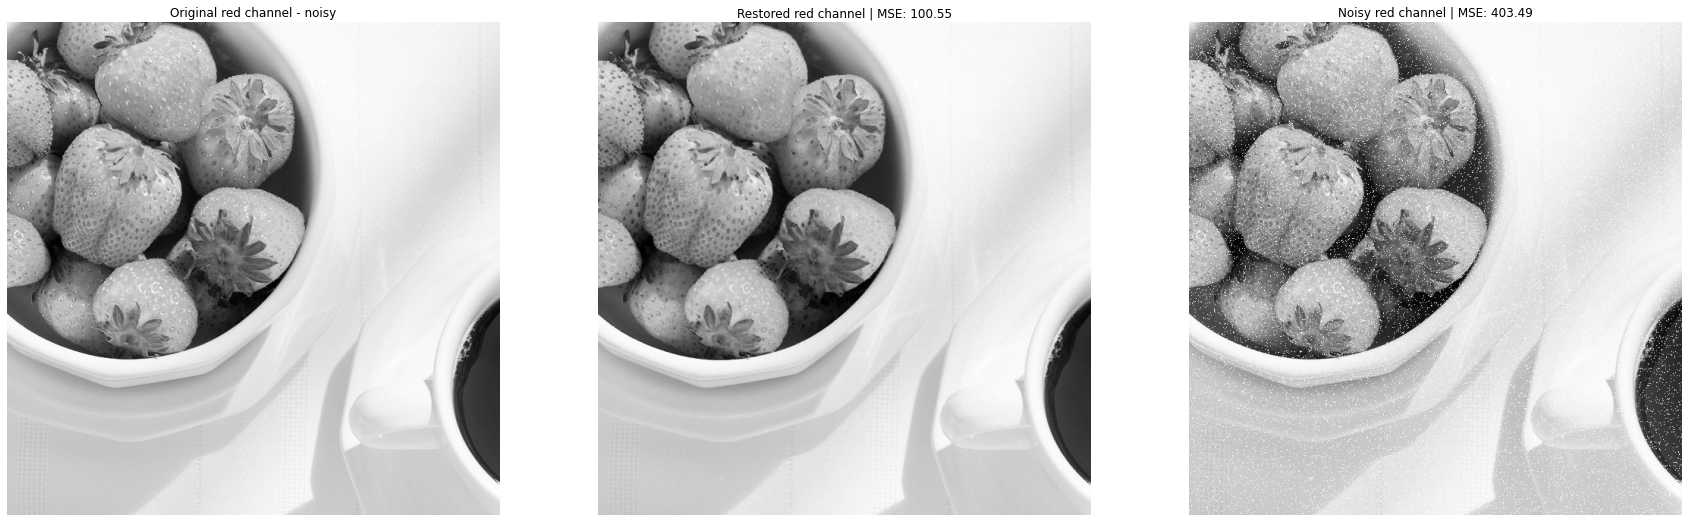

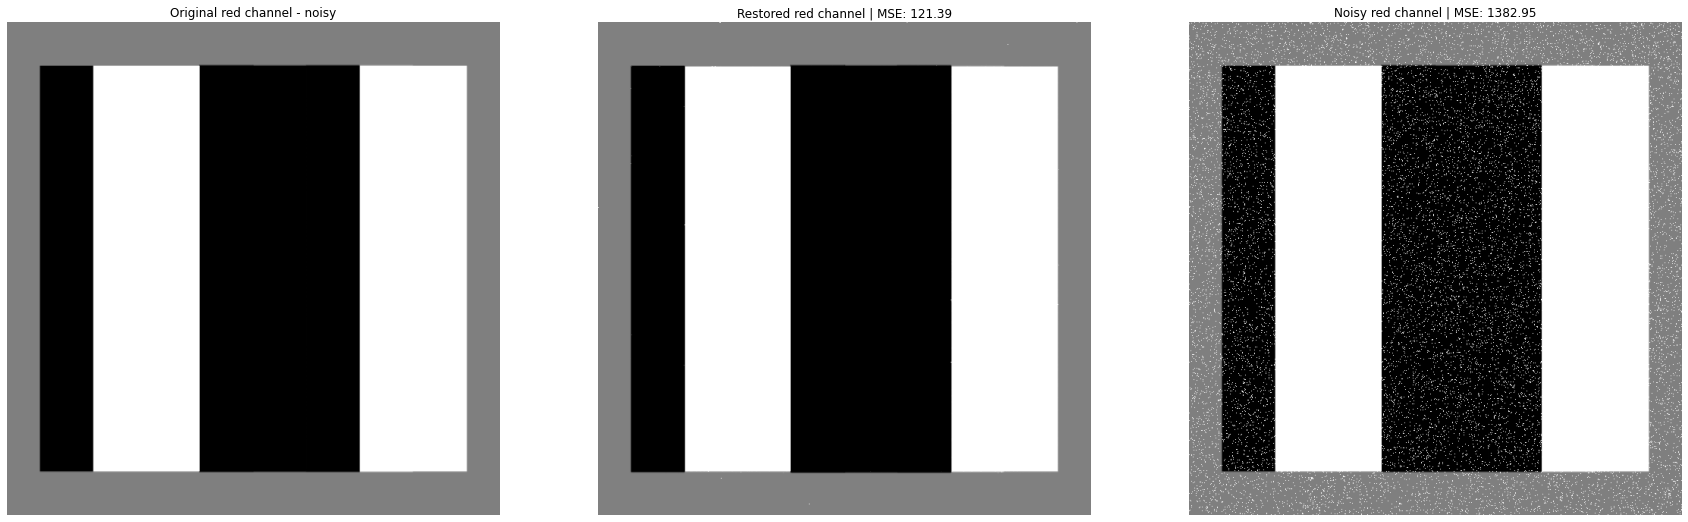

In [6]:
src_red = strawberry_red
src_bar_red = bar_red

M, Q = 1, -10.0

dst_red = apply_contra_harmonic_filter(src_red, Q, M)
dst_bar_red = apply_contra_harmonic_filter(src_bar_red, Q, M)

plot_comparison(strawberry_red_original, dst_red, strawberry_red, "Original red channel - noisy", "Restored red channel", "Noisy red channel")
plot_comparison(bar_red_original, dst_bar_red, bar_red,  "Original red channel - noisy", "Restored red channel", "Noisy red channel")

## Green channel

Median blur applied 3 times (kernel size = 3)

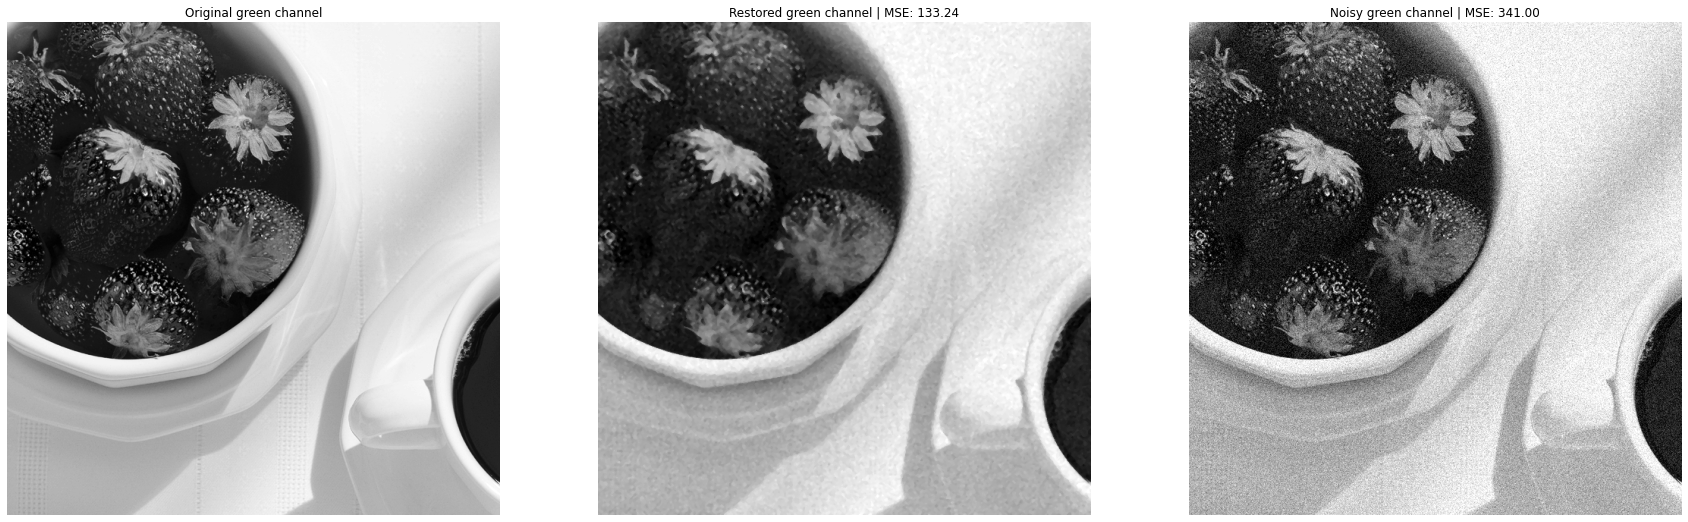

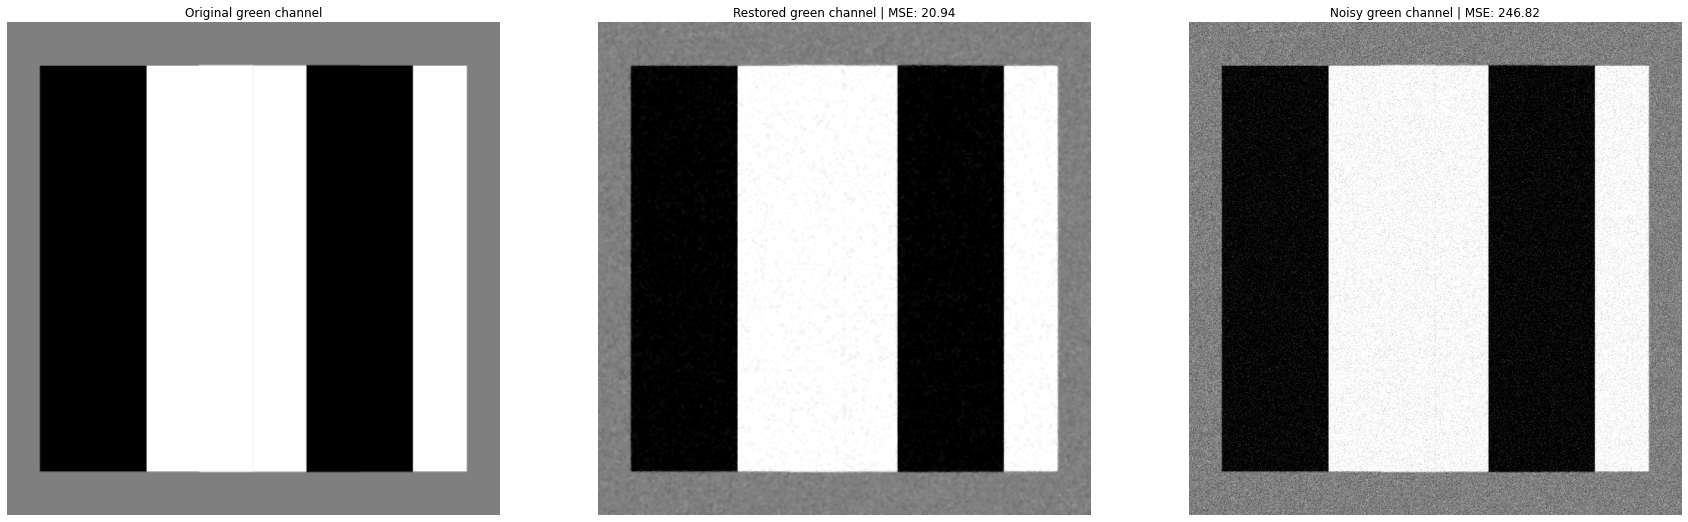

In [7]:
src_green = strawberry_green
src_bar_green = bar_green

dst_green = src_green.copy()
dst_bar_green = src_bar_green.copy()

for i in range(3):
    dst_green = cv2.medianBlur(dst_green, ksize = 3)
    dst_bar_green = cv2.medianBlur(dst_bar_green, ksize = 3)

plot_comparison(strawberry_green_original, dst_green, strawberry_green, "Original green channel", "Restored green channel", "Noisy green channel")
plot_comparison(bar_green_original, dst_bar_green, bar_green,  "Original green channel", "Restored green channel", "Noisy green channel")

## Blue channel

Adaptive median filter (M_MAX = 2) applied twice

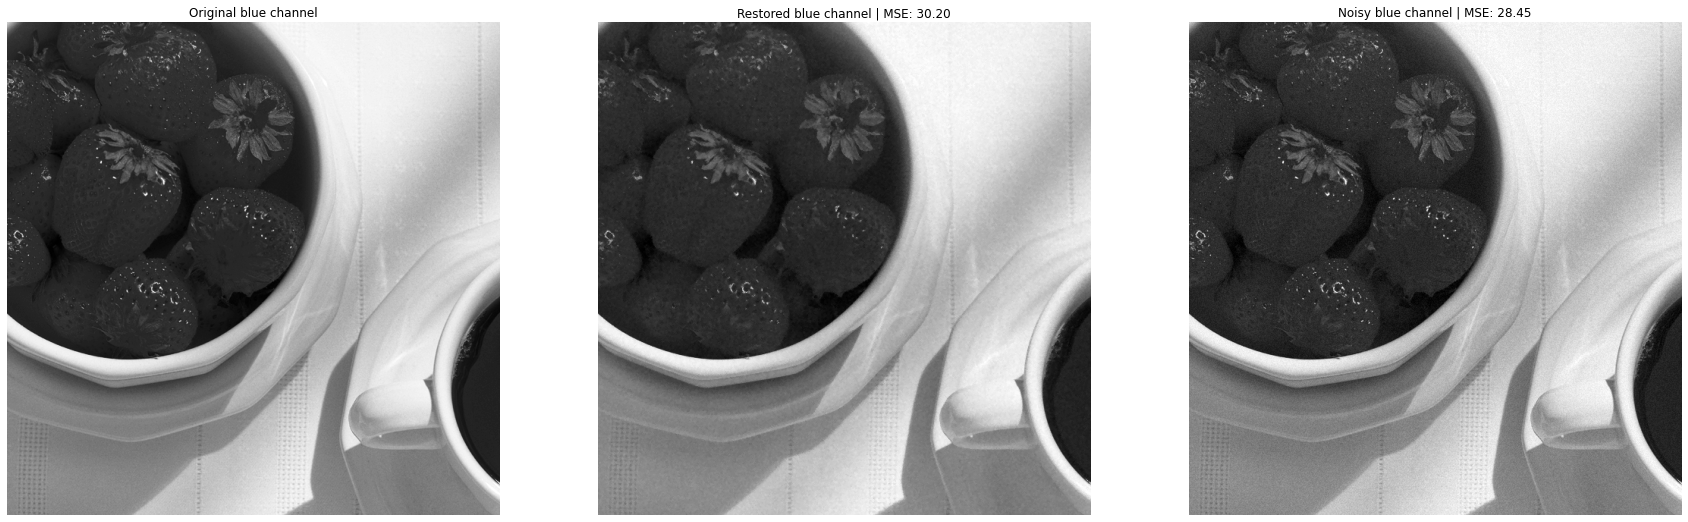

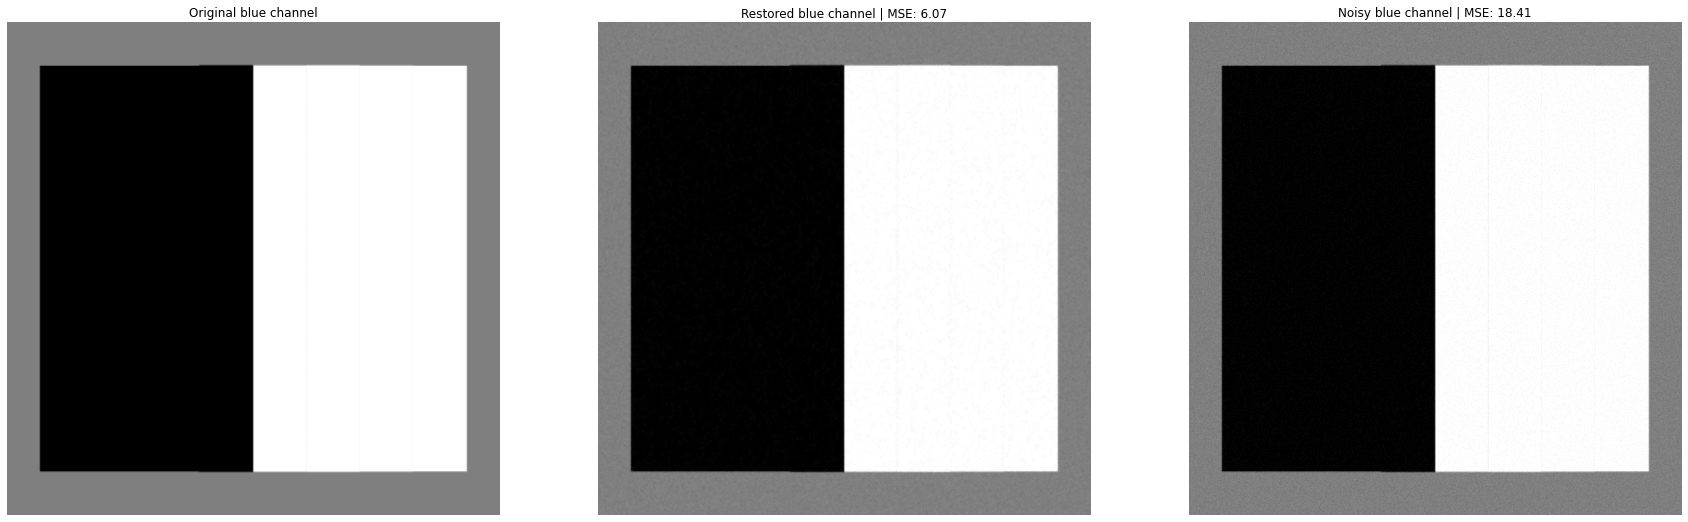

In [8]:
M_MAX = 2

src_blue = strawberry_blue
src_bar_blue = bar_blue


dst_blue = src_blue.copy()
dst_bar_blue = src_bar_blue.copy()


for i in range(2):
    dst_blue = adaptive_median_filter(dst_blue, M_MAX)
    dst_bar_blue = adaptive_median_filter(dst_bar_blue, M_MAX)

plot_comparison(strawberry_blue_original, dst_blue, strawberry_blue, "Original blue channel", "Restored blue channel", "Noisy blue channel")
plot_comparison(bar_blue_original, dst_bar_blue, bar_blue,  "Original blue channel", "Restored blue channel", "Noisy blue channel")

# Results

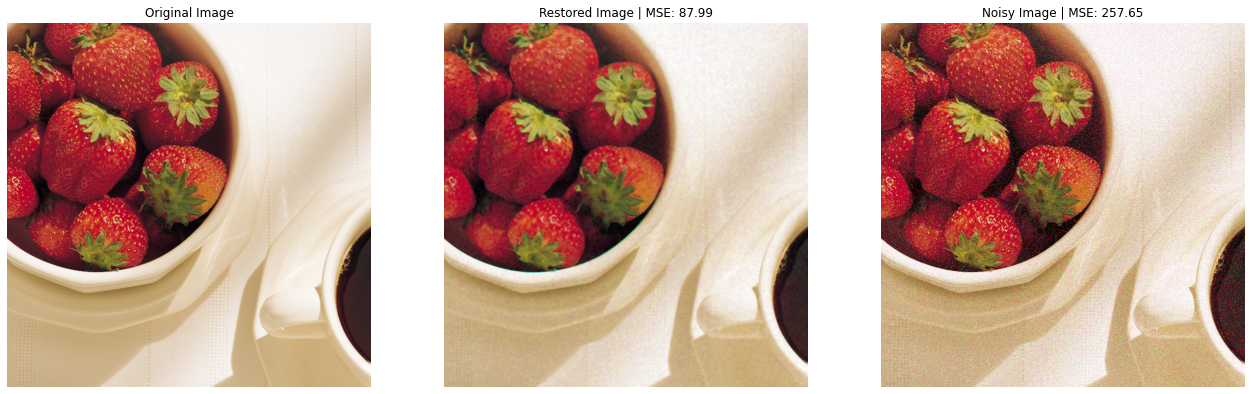

True

In [9]:
rec = np.zeros((strawberry_original.shape[0], strawberry_original.shape[1], 3))
rec[..., 2] = dst_red
rec[..., 1] = dst_green
rec[..., 0] = dst_blue

rec = np.array(rec.astype(int))

mse_strawberry = ((strawberry_original.astype(np.int) - rec) ** 2).mean()

plot_comparison_3channels(strawberry_original, rec, strawberry)

cv2.imwrite("strawberries_coffee_restored.png", rec)

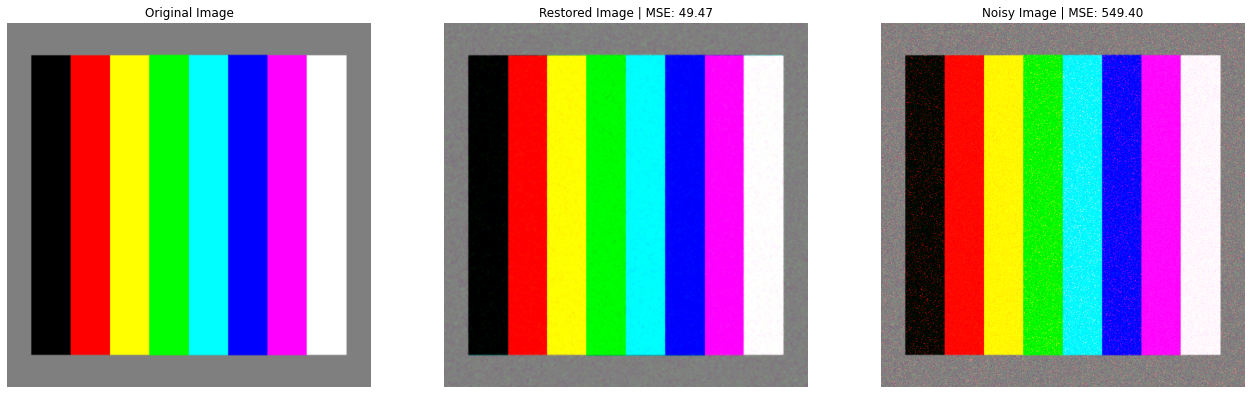

True

In [10]:
rec_bar = np.zeros((bar_original.shape[0], bar_original.shape[1], 3))
rec_bar[..., 2] = dst_bar_red
rec_bar[..., 1] = dst_bar_green
rec_bar[..., 0] = dst_bar_blue

rec_bar = rec_bar.astype(int)

mse_bar = ((bar_original.astype(np.int) - rec_bar) ** 2).mean()

plot_comparison_3channels(bar_original, rec_bar, bar_noise)

cv2.imwrite("bar_restored.png", rec_bar)

## Final remarks : 

- Overall, the noisy pictures were successfully restored and images are close to the ground-truth (based on their MSE)
- Some blur due to the median filter used to restore the green and blue channels